# Tiling images - the naive approach
In tiled image processing, the first step is cutting the image into tiles. While this could be done with numpy, we will use [dask](https://docs.dask.org/en/stable/) because it comes with multiple very useful features in this context.

In [1]:
import dask
import dask.array as da
from skimage.filters import gaussian
from skimage.data import cells3d
from stackview import imshow
from skimage.io import imread

In the first example we will use an image showing nuclei from fluorescence microscopy and just denoise the image using a Gaussian blur. We will do this tile-by-tile. For that, we first define the `procedure` that should be applied to all tiles. We build in a print statement into this function to when it's executed and how large the image is that is being processed.

In [2]:
def procedure(image):
    print("processing", image.shape)
    return gaussian(image, sigma=5)

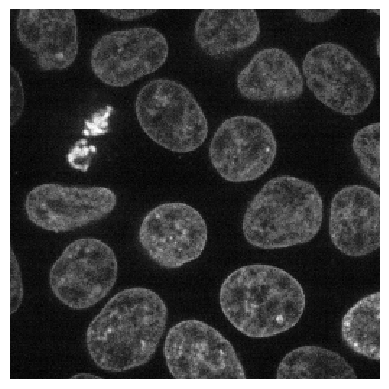

In [3]:
image = imread("data/nuclei2d.tif")
imshow(image)

After loading the image, it can be tiled like that. In dask, tiles are also called _chunks_.

In [4]:
tiles = da.from_array(image, chunks=(128, 128))
tiles

dask.array<array, shape=(256, 256), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

Next, we tell dask what to do with our tiles. We want to _map_ the function `procedure` on all individual tiles. Note, this does not process the whole image yet.

In [5]:
tile_map = da.map_blocks(procedure, tiles)

processing (0, 0)
processing (1, 1)


As we can read, the function was executed twice with very small images (0x0 and 1x1 pixels). Dask does that in principle to explore if the function works. Next, we will actually execute our `procedure` on the tiles of the image.

In [6]:
result = tile_map.compute() # Warning: This loads all image data into memory

processing (128, 128)
processing (128, 128)
processing (128, 128)
processing (128, 128)


The printed output looks a bit chaotic because dask executed the `procedure` on multiple tiles in parallel. If we inspect the result, we will see it is again an image.

In [7]:
result.shape

(256, 256)

In [8]:
type(result)

numpy.ndarray

**Note:** The `imshow` function may not work on big datasets. We are using it here for demonstration purposes.

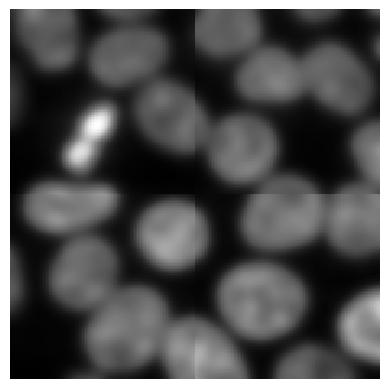

In [9]:
imshow(result)

## Border effects
When processing images tile-by-tile we always must assume that along the border artifacts appear that result from cutting the image into tiles. As our example image fits in memory, we can apply `procedure` to it and compare it to the result from the tiled image processing

processing (256, 256)


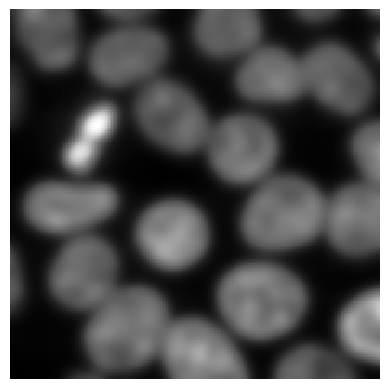

In [10]:
untiled_result = procedure(image)
imshow(untiled_result)

The differences are not obvious, but we can visualize them.

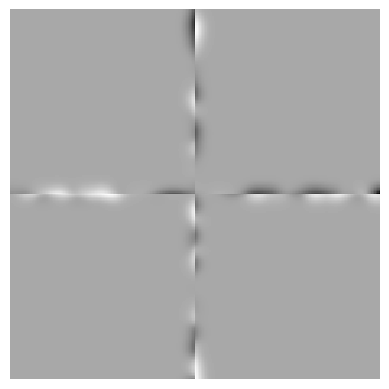

In [11]:
difference = result - untiled_result
imshow(difference)

When applying a Gaussian blur with a small sigma, these effects may be negligible. In case the effects cause severe issues in our image processing workflow, we may want to reduce or event prevent those artifacts.